Advanced Lane Finding

Udacity - Self-Driving Car NanoDegree

In this project, your goal is to write a software pipeline to identify the lane boundaries in a video, but the main output or product we want you to create is a detailed writeup of the project. Check out the writeup template for this project and use it as a starting point for creating your own writeup.
Creating a great writeup:

A great writeup should include the rubric points as well as your description of how you addressed each point. You should include a detailed description of the code used in each step (with line-number references and code snippets where necessary), and links to other supporting documents or external references. You should include images in your writeup to demonstrate how your code works with examples.

All that said, please be concise! We're not looking for you to write a book here, just a brief description of how you passed each rubric point, and references to the relevant code :).

You're not required to use markdown for your writeup. If you use another method please just submit a pdf of your writeup.
The Project

The goals / steps of this project are the following:

    Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
    Apply a distortion correction to raw images.
    Use color transforms, gradients, etc., to create a thresholded binary image.
    Apply a perspective transform to rectify binary image ("birds-eye view").
    Detect lane pixels and fit to find the lane boundary.
    Determine the curvature of the lane and vehicle position with respect to center.
    Warp the detected lane boundaries back onto the original image.
    Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

The images for camera calibration are stored in the folder called camera_cal. The images in test_images are for testing your pipeline on single frames. If you want to extract more test images from the videos, you can simply use an image writing method like cv2.imwrite(), i.e., you can read the video in frame by frame as usual, and for frames you want to save for later you can write to an image file.

To help the reviewer examine your work, please save examples of the output from each stage of your pipeline in the folder called ouput_images, and include a description in your writeup for the project of what each image shows. The video called project_video.mp4 is the video your pipeline should work well on.

The challenge_video.mp4 video is an extra (and optional) challenge for you if you want to test your pipeline under somewhat trickier conditions. The harder_challenge.mp4 video is another optional challenge and is brutal!

If you're feeling ambitious (again, totally optional though), don't stop there! We encourage you to go out and take video of your own, calibrate your camera and show us how you would implement this project from scratch!

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

In [2]:
import glob

def getObjAndImgPointsFromChessBoardImages(col = 9, row = 6):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((col*row,3), np.float32)
    objp[:,:2] = np.mgrid[0:col, 0:row].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (col,row), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    return objpoints, imgpoints

In [3]:
objpoints, imgpoints = getObjAndImgPointsFromChessBoardImages()

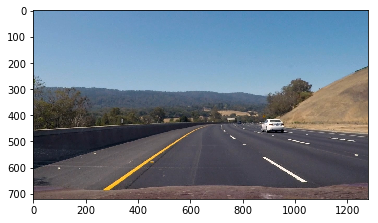

In [151]:
img = mpimg.imread('test_images/test3.jpg')
img_size = (img.shape[1], img.shape[0])
plt.imshow(img)


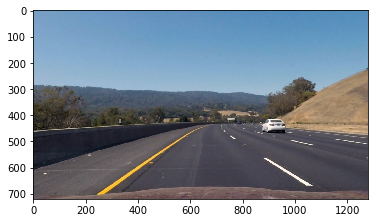

In [152]:
# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
dst = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(dst)


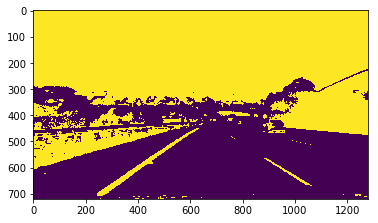

In [153]:
def hls_select(img, thresh=(40, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

hls_binary = hls_select(dst)
plt.imshow(hls_binary)

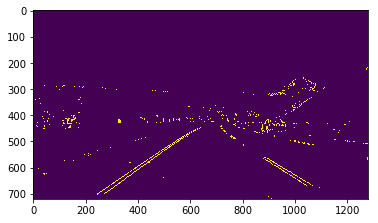

In [154]:
def abs_sobel_thresh(img, orient='x', thresh_min=35, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

sobel_img = abs_sobel_thresh(dst)
plt.imshow(sobel_img)

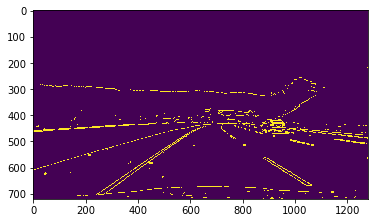

In [155]:
sobel_imgb = abs_sobel_thresh(dst,  orient='y')
plt.imshow(sobel_imgb)

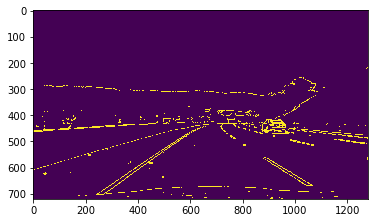

In [156]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(40, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

sobel_imgb = mag_thresh(dst)
plt.imshow(sobel_imgb)

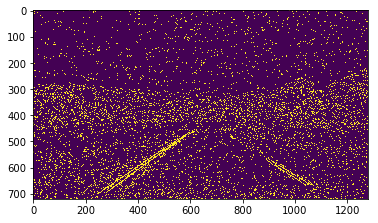

In [157]:
def dir_threshold(img, sobel_kernel=3, thresh=(-np.pi/2, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output
sobel_imgb = dir_threshold(dst, thresh=(0.8, 1.1))
plt.imshow(sobel_imgb)

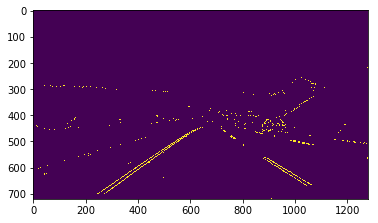

In [158]:
def CombineAllThresholds(img, thresh_min=30, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value    
    abs_x = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    abs_y = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    
    # Rescale back to 8 bit integer
    scaled_sobel_x = np.uint8(255*abs_x/np.max(abs_x))
    scaled_sobel_y = np.uint8(255*abs_y/np.max(abs_y))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel_x)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel_x >= thresh_min) & (scaled_sobel_x <= thresh_max) &
                  (scaled_sobel_y >= thresh_min) & (scaled_sobel_y <= thresh_max)
                 ] = 1    

    return binary_output

threshold = CombineAllThresholds(dst)
plt.imshow(threshold)

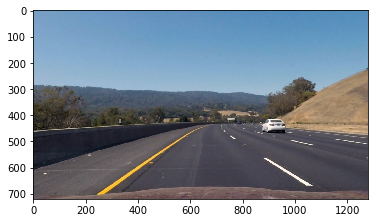

In [159]:
plt.imshow(dst)

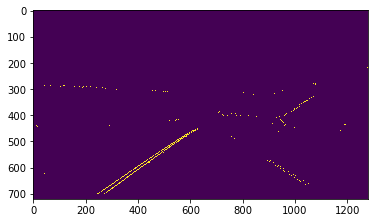

In [160]:
def CombineAllThresholdsAndHLS(img):
    hls_binary = hls_select(img)
    threshold = CombineAllThresholds(dst)

    binary_output = np.zeros_like(threshold)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(hls_binary == 1) & (threshold == 1)] = 1    

    return binary_output

final = CombineAllThresholdsAndHLS(dst)
plt.imshow(final)